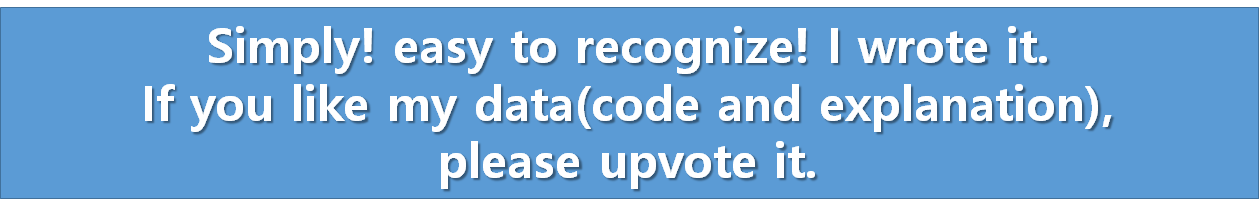

### Grid Search
하단의 코드로 Grid Search를 진행하여 Hyperparameter Tuning을 하였습니다.
참고사항 : 시간이 많이 걸립니다.

The Grid Search was conducted with the code below and Hyperparameter Tuning was performed.
Note: It takes a long time.

In [ ]:
# params = {'max_depth': [5,7,8,9,10],
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_delta_step': [3, 4, 5, 6],
#         #'min_child_weight': [2.8189, 1.5, 3,4]
#         }
        
# xgb_grid = xgb.XGBClassifier(learning_rate=0.01, n_estimators=5000, objective='binary:logistic', silent=True, nthread=1)

# folds = 5
# param_comb = 7
# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1004)

# random_search = RandomizedSearchCV(xgb_grid, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4
#                                    , cv=skf.split(df_train_x,df_train_y), verbose=3, random_state=1004)

# random_search.fit(df_train_x,df_train_y)

In [ ]:
# print('\n All results:' + random_search.cv_results_)
# print('\n Best estimator:' + random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)

# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('grid-search-results.csv', index=False)

In [ ]:
import seaborn as sns
import sys
import csv
import datetime
import operator
import joblib
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from statsmodels.formula.api import ols
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew, probplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import StratifiedKFold

### Data 불러오기(Read Data set)

In [ ]:
df_train = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/train.csv')
df_test = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/test.csv')

In [ ]:
# 7:3으로 제공된 train data를 train과 validation data로 구분

from sklearn.model_selection import train_test_split

random_state_val =42
test_size_val =0.3
train,validation = train_test_split(df_train, test_size = test_size_val, random_state = random_state_val)

In [ ]:
y_nm = 'target'

df_train_x = train.drop(y_nm, axis = 1)
df_train_y = pd.DataFrame(train[y_nm])

df_val_x = validation.drop(y_nm, axis = 1)
df_val_y = pd.DataFrame(validation[y_nm])

df_test_x = df_test

In [ ]:
# numeric data와 char
num_cols = [col for col in df_train_x.columns if df_train_x[col].dtype in ["float16","float32","float64"]]
cat_cols = [col for col in df_train_x.columns if df_train_x[col].dtype not in ["float16","float32","float64"]]

In [ ]:
# categorical data type data에 대하여 target encoding을 사용하였습니다.
# Proceed with TargetEncoding for data of the categorical data type.

y = train["target"].copy()

for cols in cat_cols:
    enc = TargetEncoder(cols=[cols])
    df_train_x = enc.fit_transform(df_train_x, y)
    df_val_x = enc.transform(df_val_x)
    df_test_x = enc.transform(df_test_x)

In [ ]:
scaler = QuantileTransformer()
scaler.fit(df_train_x)
df_train_x = pd.DataFrame(scaler.transform(df_train_x))
df_val_x = pd.DataFrame(scaler.transform(df_val_x))
df_test_x = pd.DataFrame(scaler.transform(df_test_x))

### 모델링(Modeling)

In [ ]:
XGBClassifier = xgb.XGBClassifier(max_depth = 5,
                                 learning_rate = 0.007,
                                 n_estimators = 7000,
                                 objective = 'binary:logistic',
                                 booster = 'gbtree',
                                 gamma = 1.5,
                                 max_delta_step = 3,
                                 min_child_weight = 10,
                                 subsample = 0.6,
                                 colsample_bytree = 0.8,
                                 n_jobs = -1
                                 )

In [ ]:
start = datetime.datetime.now()
xgb = XGBClassifier.fit(df_train_x.values,
                       df_train_y.values.ravel(),
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)], 
                       eval_metric = 'auc',
                       early_stopping_rounds = 15,
                       verbose = True)
end = datetime.datetime.now()
end-start

In [ ]:
fi_vals = xgb.get_booster().get_score(importance_type = 'weight')
fi_dict = {df_train_x.columns[i]:float(fi_vals.get('f'+str(i),0.)) for i in range(len(df_train_x.columns))}
feature_importance_ = sorted(fi_dict.items(), key=operator.itemgetter(1), reverse=True)
feature_importance_result = OrderedDict(feature_importance_)

importance = pd.DataFrame(feature_importance_)
importance.columns = ['feature','weight']
importance.head(10)

In [ ]:
importance_ten = importance[:10]
importance_ten.set_index('feature').sort_values(by='weight').plot(kind='barh', figsize=(5, 5))

In [ ]:
fpr, tpr, _ = roc_curve(df_val_y, xgb.predict_proba(df_val_x.values)[:, 1])
roc_auc = auc(fpr, tpr)

result_lst =[]
max_roc_auc =0.
opt_threshold =0.
val_y_prob = xgb.predict_proba(df_val_x.values)[:, 1]

for n in range(0,50):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if max_roc_auc <= roc_auc:
        max_roc_auc = roc_auc
        opt_threshold = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max roc_auc =%f, optimized_threshold=%f'%(max_roc_auc, opt_threshold))
print('Complete')

In [ ]:
predict_xgb = xgb.predict_proba(df_train_x.values)[:,1]
pred_train = np.where(predict_xgb > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_train_y.values.ravel(), pred_train, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_train_y.values.ravel(), pred_train),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_train_y.values.ravel(), pred_train))

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_train_y.values.ravel(), predict_xgb)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

In [ ]:
pred_test = xgb.predict_proba(df_test_x.values)[:,1]

test_result= pd.DataFrame(pred_test)
test_result.columns = ['target']
predict = test_result['target']
Id_No = df_test['id']
submission = pd.DataFrame({'id': Id_No, 'target': predict})
submission['target'] = submission['target'].astype('float32')
submission.to_csv('submission.csv', index=False)
submission.head()